# Beginners Guide to `caskade`

Here we will introduce all of the relevant concepts and capabilities of `caskade` and how to build numerical simulators.

In [1]:
import caskade as ck
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from time import time

## Basic Template

All `caskade` simulators follow the same basic template. Certain ingredients are always involved:

- Subclass the `Module` object
- Call the `super().__init__(name)` at the top
- Create some `Param` attributes
- Decorate a function(s) with `@forward`
- use the params (by name) in the decorated function(s)

You can also provide a name for the `Module`, though this is optional.

In [2]:
class Gaussian(ck.Module):
    def __init__(self, name, x0=None, q=None, phi=None, sigma=None, I0=None):
        super().__init__(name)
        self.x0 = ck.Param("x0", x0, shape=(2,))  # position
        self.q = ck.Param("q", q)  # axis ratio
        self.phi = ck.Param("phi", phi)  # orientation
        self.sigma = ck.Param("sigma", sigma)  # width
        self.I0 = ck.Param("I0", I0)  # intensity

    @ck.forward
    def _r(self, x, y, x0=None, q=None, phi=None):
        x, y = x - x0[..., 0], y - x0[..., 1]
        s, c = torch.sin(phi), torch.cos(phi)
        x, y = c * x - s * y, s * x + c * y
        return (x**2 + (y * q) ** 2).sqrt()

    @ck.forward
    def brightness(self, x, y, sigma=None, I0=None):
        return I0 * (-self._r(x, y) ** 2 / sigma**2).exp()

We may now create instances of this simulator, and inspect what the compute graph looks like.

my first module|Gaussian
    x0|dynamic
    q|dynamic
    phi|dynamic
    sigma|static: 0.2
    I0|static: 1


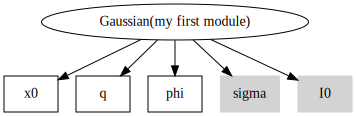

In [3]:
firstsim = Gaussian("my first module", sigma=0.2, I0=1.0)
print(firstsim)  # print the graph
firstsim.graphviz()  # show the graph

Best practice is to initialize the simulator with initial values for all params (or provide values shortly after creating the simulator as part of initialization).

Use the `to_dynamic` and `to_static` to control the status of each param or module.

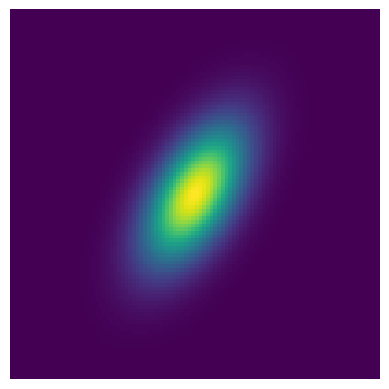

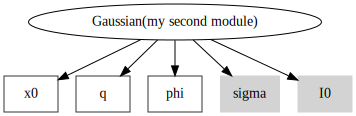

In [4]:
secondsim = Gaussian("my second module", x0=(0, 0), q=0.5, phi=3.14 / 3, sigma=0.2, I0=1.0)
x, y = torch.meshgrid(torch.linspace(-1, 1, 100), torch.linspace(-1, 1, 100), indexing="ij")
secondsim.to_dynamic()  # all params owned by secondsim are now dynamic
secondsim.sigma.to_static()  # sigma is now static
secondsim.I0.to_static()  # I0 is now static
params = secondsim.build_params_array()  # automatically build a tensor for the dynamic params
plt.imshow(secondsim.brightness(x, y, params), origin="lower")
plt.axis("off")
plt.show()
secondsim.graphviz()  # show the graph

## Different ways to pass the parameters

W can pass the parameters into a `caskade` forward method as one of a `list`, a 1D `Tensor`, or a `dict`. 

Params list: [tensor([0, 0]), tensor(0.5000), tensor(1.0467)]
Params tensor: tensor([0.0000, 0.0000, 0.5000, 1.0467])
Params dict: {'x0': tensor([0, 0]), 'q': tensor(0.5000), 'phi': tensor(1.0467)}


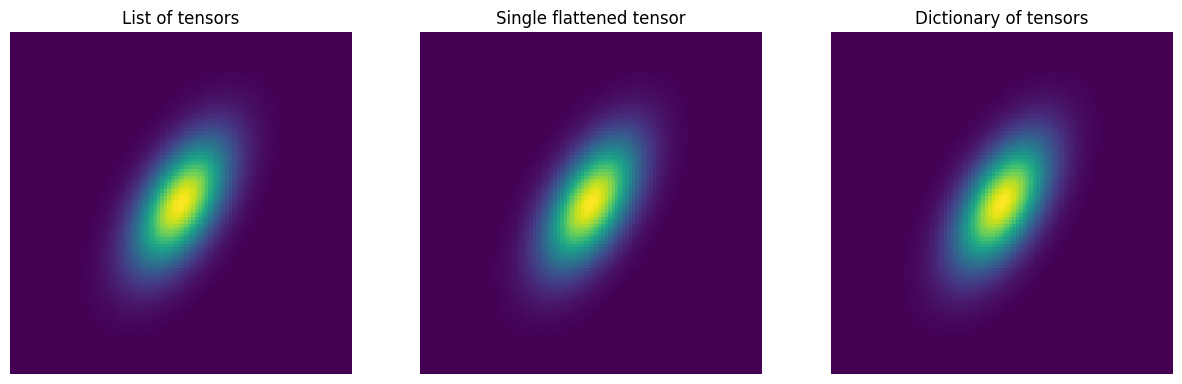

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# List of tensors
params_list = secondsim.build_params_list()
print("Params list:", params_list)
ax[0].imshow(secondsim.brightness(x, y, params_list), origin="lower")
ax[0].axis("off")
ax[0].set_title("List of tensors")

# Single flattened tensor
params_tensor = secondsim.build_params_array()
print("Params tensor:", params_tensor)
ax[1].imshow(secondsim.brightness(x, y, params_tensor), origin="lower")
ax[1].axis("off")
ax[1].set_title("Single flattened tensor")

# Dictionary of tensors, using attribute names of either Param or Module objects
params_dict = secondsim.build_params_dict()
print("Params dict:", params_dict)
ax[2].imshow(secondsim.brightness(x, y, params_dict), origin="lower")
ax[2].axis("off")
ax[2].set_title("Dictionary of tensors")
plt.show()

Next, once we have the `params` we can either pass it as the last positional argument, as a `params=` keyword, or we can set them as `static`.

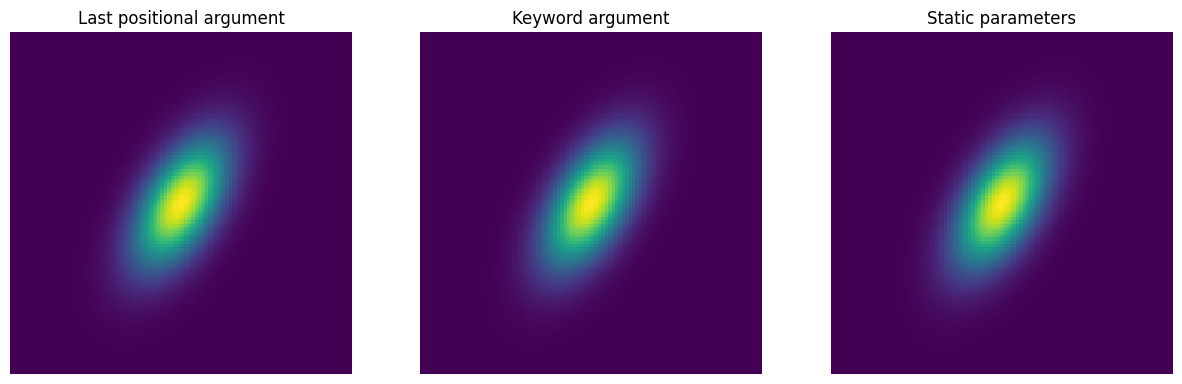

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Pass as last positional argument
ax[0].imshow(secondsim.brightness(x, y, params_list), origin="lower")
ax[0].axis("off")
ax[0].set_title("Last positional argument")

# Pass as keyword argument
ax[1].imshow(secondsim.brightness(x, y, params=params_list), origin="lower")
ax[1].axis("off")
ax[1].set_title("Keyword argument")

# Set parameters as static
secondsim.to_static()
ax[2].imshow(secondsim.brightness(x, y), origin="lower")
ax[2].axis("off")
ax[2].set_title("Static parameters")
# Set them back to dynamic
secondsim.x0.to_dynamic()
secondsim.q.to_dynamic()
secondsim.phi.to_dynamic()
plt.show()

## The `pointer` parameter

So far we have only looked at `dynamic` and `static` parameters. `caskade` allows users to build complex simulators with relationships between parameters. Next lets see the `pointer` type: 

- `dynamic` is given as input when calling a `@forward` method
- `static` is a fixed value
- `pointer` returns the value computed from other nodes in the graph

In [7]:
thirdsim = Gaussian("my third module", phi=3.14 * 5 / 6, q=0.2, sigma=0.2, I0=0.5)
thirdsim.x0 = secondsim.x0  # now they share the same position

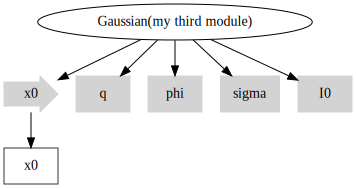

In [8]:
thirdsim.graphviz()

As you can see, a `pointer` parameter is represented in the graph as a shaded arrow. It will now return the same value as the `x0` parameter in `secondsim`.

## Nested Modules

The real power of `caskade` comes from nesting `Module` objects to build complex scientific simulators, all while keeping the flexible and robust interfaces seen above.

In [9]:
class Combined(ck.Module):
    def __init__(self, name, first, second):
        super().__init__(name)
        self.first = first  # Modules are automatically registered
        self.second = second

    @ck.forward
    def brightness(self, x, y):
        return self.first.brightness(x, y) + self.second.brightness(x, y)

my combined module|Combined
    my second module|Gaussian
        x0|dynamic value: [0, 0]
        q|dynamic value: 0.5
        phi|dynamic value: 1.05
        sigma|static: 0.2
        I0|static: 1
    my third module|Gaussian
        x0|pointer: [0, 0]
            x0|dynamic value: [0, 0]
        q|static: 0.2
        phi|static: 2.62
        sigma|static: 0.2
        I0|static: 0.5


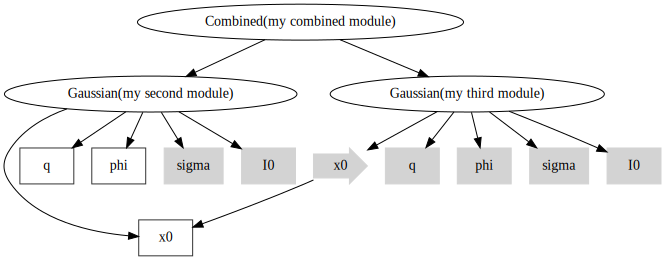

In [10]:
combinedsim = Combined("my combined module", secondsim, thirdsim)
print(combinedsim)
combinedsim.graphviz()

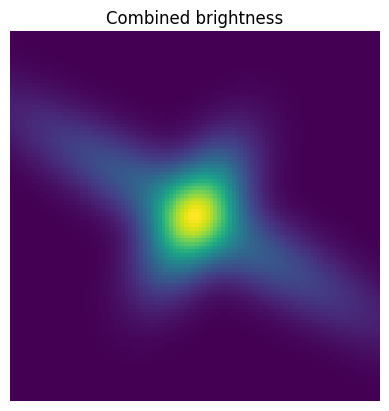

In [11]:
# same params as before since secondsim is all static or pointers to firstsim
plt.imshow(combinedsim.brightness(x, y, combinedsim.build_params_array()), origin="lower")
plt.axis("off")
plt.title("Combined brightness")
plt.show()

## Functional `pointer`s

A `pointer` parameter determines it's value from other parameters. This can go beyond just returning the same value. One can define an arbitrary function.

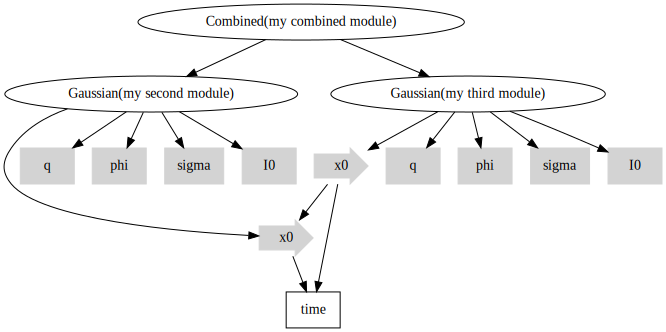

In [12]:
simtime = ck.Param("time")  # create a parameter for time
secondsim.x0 = lambda p: (-p.time.value + 0.5) * torch.tensor((1, -1))
secondsim.x0.link(simtime)
thirdsim.x0 = lambda p: p.time.value * torch.tensor((1, 1)) - 0.5
thirdsim.x0.link(simtime)

# Use `static_value` to set the value and set to static
# Similarly use `dynamic_value` to set value and set dynamic
secondsim.q.static_value(0.5)
secondsim.phi.static_value(3.14 / 3)

combinedsim.graphviz()

In [13]:
B = 64
fig, ax = plt.subplots()
img = ax.imshow(combinedsim.brightness(x, y, torch.tensor([0.0])), origin="lower", vmin=0, vmax=1.5)
ax.set_title("Brightness at time 0")


def update(i):
    img.set_data(combinedsim.brightness(x, y, torch.tensor([i / B])))
    ax.set_title(f"Brightness at time {i / B:.2f}")
    return img


ani = animation.FuncAnimation(fig, update, frames=B, interval=60)

plt.close()

# Or display the animation inline
HTML(ani.to_jshtml())

## Interacting with PyTorch

The above animation was made with a `for-loop`, but using the `PyTorch` `vmap` function we can produce the frames a lot faster. In this case, `vmap` is up to 5x faster than the `for-loop` but with lots of fluctuations.

In [14]:
batched_params_tensor = torch.linspace(0, 1, 64).reshape(
    64, 1
)  # only 1 param "time" so last dim is 1

start = time()
result = []
for i in range(B):
    result.append(combinedsim.brightness(x, y, batched_params_tensor[i]))
result = torch.stack(result)
print("for-loop time taken: ", time() - start)

vbrightness = torch.vmap(combinedsim.brightness, in_dims=(None, None, 0))
start = time()
result = vbrightness(x, y, batched_params_tensor)
print("vmap time taken: ", time() - start)

for-loop time taken:  0.5124452114105225
vmap time taken:  0.09484076499938965


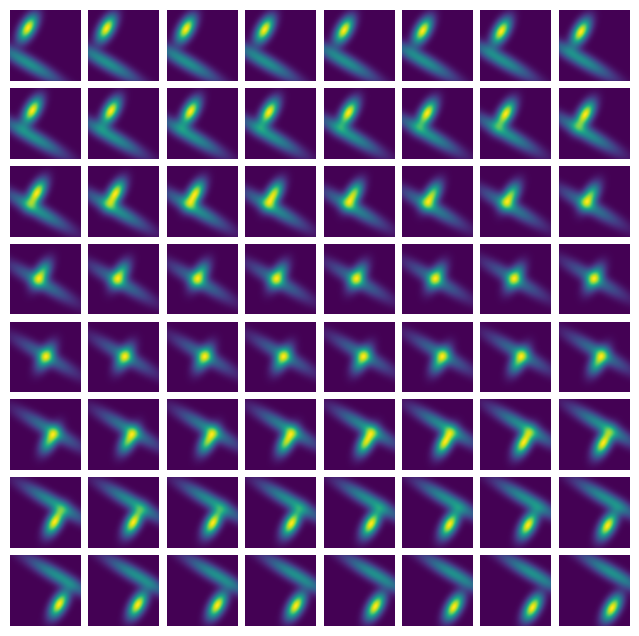

In [15]:
fig, axarr = plt.subplots(8, 8, figsize=(8, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, ax in enumerate(axarr.flat):
    ax.imshow(result[i], origin="lower")
    ax.axis("off")
plt.show()

We can also use `PyTorch` autograd functionalities on `caskade` simulators. All of the `PyTorch` calculus operations will work on `caskade` simulators, so one may compute a likelihood and perform gradient descent very easily, to name one example.

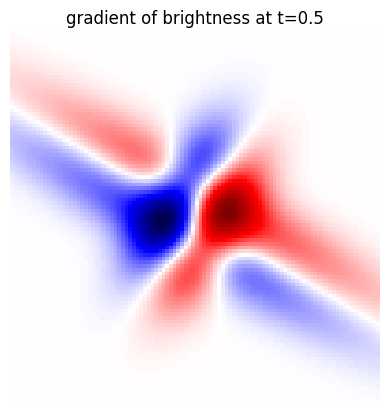

In [16]:
# using PyTorch autograd
params_tensor = torch.tensor([0.5])
plt.imshow(
    torch.func.jacfwd(combinedsim.brightness, argnums=2)(x, y, params_tensor),
    origin="lower",
    cmap="seismic",
)
plt.axis("off")
plt.title("gradient of brightness at t=0.5")
plt.show()

## Use `caskade` with numpy, JAX, or PyTorch

It is possible to use `caskade` with other array like types like numpy and jax. You'll need to set the backend for `caskade` to run things properly. Ideally you should set the environment variable `CASKADE_BACKEND` and then `caskade` will run everything with your desired backend. The options are `torch`, `numpy`, and `jax`. If you have a linux system running bash you can do:
```bash
export CASKADE_BACKEND="numpy"
```
to switch over to run everything with numpy, and similar commands for any other backend option. The default is `torch` since that's what `caskade` was originally developed in. You can also change the backend on the fly like below, just note that this is a bit dangerous since you can have objects running around with different types. Ideally, you would set the backend at the top of your script and leave it as the same value throughout.

In [18]:
# numpy backend
ck.backend.backend = "numpy"
p = ck.Param("p", 1.0)
print("with numpy backend, p type:", type(p.value))

# jax backend
ck.backend.backend = "jax"
p = ck.Param("p", 1.0)
print("with jax backend, p type:", type(p.value))

# torch backend
ck.backend.backend = "torch"
p = ck.Param("p", 1.0)
print("with torch backend, p type:", type(p.value))

with numpy backend, p type: <class 'numpy.ndarray'>
with jax backend, p type: <class 'jaxlib._jax.ArrayImpl'>
with torch backend, p type: <class 'torch.Tensor'>


And we're done! Those are all the elemental abilities of `caskade`, I hope that by this point you have a sense of the vast possibilities of simulators that can be constructed. This is only the tip of the iceberg for `caskade`, check out the advanced tutorial for much more information about constructing simulators! Or check out [caustics](https://caustics.readthedocs.io/) to see `caskade` in action!


Happy science-ing!